# TenGeoP-SARwv CNN model #
### Diego Xavier Bezerra - INPE ###
### 30-Sep-20 ###


WANG, Chen et al. Labeled SAR imagery dataset of ten geophysical phenomena from Sentinel-1 wave mode (TenGeoP-SARwv). 2018.

SZEGEDY, Christian et al. Going deeper with convolutions. In: Proceedings of the IEEE conference on computer vision and pattern recognition. 2015. p. 1-9.

https://machinelearningmastery.com/how-to-load-large-datasets-from-directories-for-deep-learning-with-keras/

https://stackoverflow.com/questions/46717742/split-data-directory-into-training-and-test-directory-with-sub-directory-structu

https://maelfabien.github.io/deeplearning/inception/#in-keras

In [110]:
# Import Libs
from keras.models import Sequential
from keras.layers import concatenate
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.utils import normalize
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, GlobalAveragePooling2D
from keras.models import Model
from tensorflow.keras.callbacks import TensorBoard

import pydot
import graphviz
from keras.utils.vis_utils import plot_model

import pydot
import numpy as np
import pandas as pd
import os
import cv2
import time
from glob import glob
import gdal
from gdalconst import *
import random
import pickle

from matplotlib import pyplot as plt

In [107]:
def tiff2arr(img):
    '''
    Loads TIFF image into a numpy array
    '''
    dset = gdal.Open(img, GA_ReadOnly)
    arr = dset.GetRasterBand(1).ReadAsArray()
    dset = None
    return arr

In [109]:
# Set parameters
BATCH_SIZE = 32
IMG_SIZE = 100
N_EPOCHS = 3
N_CLASSES = 7
MODEL_NAME = f"TenGeoP-Inception-{int(time.time())}"
tensorboard = TensorBoard(log_dir=rf"D:\ocean_features\logs\{MODEL_NAME}")

[[ 4781  3765  4105 ...  4368  4508  3811]
 [12804 11639 10635 ... 12378 11203 12132]
 [17234 12154 13210 ... 13974 15619 13380]
 ...
 [11099 14242 11254 ... 13756 12295 14647]
 [11687 11529 11056 ... 13353 15291 10193]
 [ 4224  4525  4164 ...  4573  3848  3142]]
(493, 547)
2535 21364


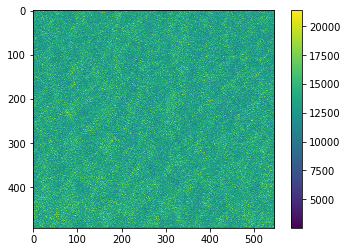

In [105]:
# Set data dir
DATADIR = r"D:\ocean_features\wang_dataset"
CATEGORIES = ['F', 'G', 'H', 'I', 'M', 'N', 'O']

# Check raw image
for CAT in CATEGORIES[2:]:
    path = os.path.join(DATADIR, CAT)
    for img in os.listdir(path):
        
        img_arr = tiff2arr(os.path.join(path, img))
        # img_arr = normalize(img_arr)
        # new_array = cv2.resize(img_arr, (IMG_SIZE, IMG_SIZE))
        
        
        plt.imshow(img_arr), plt.colorbar()
        # plt.hist(img_arr, bins=256)
        print(img_arr)
        print(img_arr.shape)
        print(np.min(img_arr), np.max(img_arr))

        
        break
    break

In [92]:
# Dataset is too large to fit into RAM, so we create a data generator
datagen = ImageDataGenerator(validation_split=0.3)

# prepare iterators for each dataset
train_it = datagen.flow_from_directory(DATADIR, class_mode='categorical', color_mode='grayscale',
                                       target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, shuffle=True, subset='training')
validate_it = datagen.flow_from_directory(DATADIR, class_mode='categorical', color_mode='grayscale',
                                       target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, shuffle=True, subset='validation')

# confirm the iterator works
batchX, batchy = train_it.next()
print('Batch shape=%s, min=%.3f, max=%.3f' % (batchX.shape, batchX.min(), batchX.max()))

C:\Users\diego_home\miniconda3\envs\py368\lib\site-packages\keras_preprocessing\image\utils.py:173: UserWarning: Using ".tiff" files with multiple bands will cause distortion. Please verify your output.
  warnings.warn('Using ".tiff" files with multiple bands '


Found 18547 images belonging to 7 classes.
Found 7947 images belonging to 7 classes.
Batch shape=(32, 100, 100, 1), min=13.000, max=255.000


In [86]:
# Here we build CNN inception model (GoogLeNet)
model = Sequential()
input_img = Input(shape=(IMG_SIZE, IMG_SIZE, 1))

# 1st layer
layer_1 = Convolution2D(10, (1,1), padding='same', activation='relu')(input_img)
layer_1 = Convolution2D(10, (3,3), padding='same', activation='relu')(layer_1)

layer_2 = Convolution2D(10, (1,1), padding='same', activation='relu')(input_img)
layer_2 = Convolution2D(10, (5,5), padding='same', activation='relu')(layer_2)

layer_3 = MaxPooling2D((3,3), strides=(1,1), padding='same')(input_img)
layer_3 = Convolution2D(10, (1,1), padding='same', activation='relu')(layer_3)

mid_1 = concatenate([layer_1, layer_2, layer_3], axis = 3)

flat_1 = Flatten()(mid_1)

# dense layers
dense_1 = Dense(1200, activation='relu')(flat_1)
dense_2 = Dense(600, activation='relu')(dense_1)
dense_3 = Dense(150, activation='relu')(dense_2)
output = Dense(N_CLASSES, activation='softmax')(dense_3)

In [87]:
model = Model([input_img], output)
model.summary()

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 100, 100, 1)  0                                            
__________________________________________________________________________________________________
conv2d_36 (Conv2D)              (None, 100, 100, 10) 20          input_9[0][0]                    
__________________________________________________________________________________________________
conv2d_38 (Conv2D)              (None, 100, 100, 10) 20          input_9[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_8 (MaxPooling2D)  (None, 100, 100, 1)  0           input_9[0][0]                    
___________________________________________________________________________________________

In [88]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [89]:
model.fit_generator(
    train_it,
    steps_per_epoch = train_it.samples // BATCH_SIZE,
    validation_data = validate_it, 
    validation_steps = validate_it.samples // BATCH_SIZE,
    epochs = N_EPOCHS,
    callbacks=[tensorboard])


Epoch 1/3
579/579 [==============================] - 2763s 5s/step - loss: 456.8452 - accuracy: 0.1734 - val_loss: 1.8225 - val_accuracy: 0.1849
Epoch 2/3
579/579 [==============================] - 2609s 5s/step - loss: 1.8671 - accuracy: 0.1840 - val_loss: 1.9409 - val_accuracy: 0.1855
Epoch 3/3
579/579 [==============================] - 2631s 5s/step - loss: 1.8673 - accuracy: 0.1863 - val_loss: 1.9159 - val_accuracy: 0.1809
